In [2]:
import kaolin
kaolin.io.usd?

Type:        module
String form: <module 'kaolin.io.usd' from '/opt/conda/envs/kaolin/lib/python3.8/site-packages/kaolin/io/usd/__init__.py'>
File:        /opt/conda/envs/kaolin/lib/python3.8/site-packages/kaolin/io/usd/__init__.py
Docstring:   <no docstring>

In [3]:
dir(kaolin.io.usd)

['__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'add_mesh',
 'add_pointcloud',
 'add_voxelgrid',
 'create_stage',
 'export_mesh',
 'export_meshes',
 'export_pointcloud',
 'export_pointclouds',
 'export_voxelgrid',
 'export_voxelgrids',
 'get_authored_time_samples',
 'get_mesh_prim_materials',
 'get_pointcloud_bracketing_time_samples',
 'get_pointcloud_scene_paths',
 'get_raw_mesh_prim_geometry',
 'get_scene_paths',
 'import_mesh',
 'import_meshes',
 'import_pointcloud',
 'import_pointclouds',
 'import_voxelgrid',
 'import_voxelgrids',
 'mesh',
 'pointcloud',
 'utils',
 'voxelgrid']

In [18]:
!rm -rf new_stage.usda

In [5]:
from kaolin.io.usd import *
import torch
vertices = torch.rand(3, 3)
faces = torch.tensor([[0, 1, 2]])
export_mesh('./new_stage.usda', vertices=vertices, faces=faces)

Usd.Stage.Open(rootLayer=Sdf.Find('/app/kaolings/gaussian-splatting/new_stage.usd'), sessionLayer=Sdf.Find('anon:0x58cdb638d590:new_stage-session.usda'), pathResolverContext=Ar.ResolverContext(Ar.DefaultResolverContext(['/app/kaolings/gaussian-splatting'])))

In [3]:
from kaolin.io.usd import create_stage, add_voxelgrid
import torch
stage = create_stage('./new_stage.usda')
voxelgrid = torch.rand(32, 32, 32) > 0.5
stage = add_voxelgrid(stage, voxelgrid, '/World/VoxelGrids/voxelgrid_0')
stage.Save()

In [7]:
stage = create_stage('./new_stage.usda')
points = torch.rand(100, 3)
add_pointcloud(stage, points, '/World/PointClouds/pointcloud_0')
stage.Save()

In [14]:
from kaolin.io.usd import create_stage, add_voxelgrid
import torch
from pxr import Usd, UsdGeom, Gf, UsdShade

In [15]:

stage = create_stage('./new_stage.usda')
# 获取 USD 对象 (例如，一个平面)
plane = UsdGeom.Plane.Get(stage, "/World/Plane")
# 获取材质
material = UsdShade.Material.Get(stage, "/World/PlaneMaterial")
# 获取纹理
texture = UsdShade.Texture.Get(stage, "/World/PlaneMaterial/DiffuseTexture")

# 将 image_data 更新到纹理
texture.SetAsset(image_data)

AttributeError: module 'pxr.UsdShade' has no attribute 'Texture'

## 使用HDRI 作为画布

In [16]:
import omni.usd
from pxr import Usd, UsdGeom, Gf, UsdShade
import numpy as np

def image_update(camera_info):
    # 根据相机信息生成 HDRI 图像数据
    # 这里的 generate_hdri_image 函数需要根据 camera_info 
    # 生成一个 360 度的全景图作为 HDRI
    image_data = generate_hdri_image(camera_info)
    return image_data

def update_hdri_texture(image_data):
    # 获取 USD 阶段
    stage = omni.usd.get_context().get_stage()
    # 获取环境光照节点 （假设路径为 "/World/EnvironmentLight"）
    env_light = UsdGeom.SphereLight.Get(stage, "/World/EnvironmentLight")

    # 获取或创建材质
    material_path = "/World/EnvironmentMaterial"
    material = UsdShade.Material.Get(stage, material_path)
    if not material:
        material = UsdShade.Material.Define(stage, material_path)

    # 获取或创建纹理
    texture_path = material_path + "/HdriTexture"
    texture = UsdShade.Texture.Get(stage, texture_path)
    if not texture:
        texture = UsdShade.Texture.Define(stage, texture_path)

    # 将 image_data 转换为 numpy 数组
    image_array = np.array(image_data, dtype=np.float32)  # 假设是浮点 HDR 数据

    # 设置纹理的图像数据 (这部分可能需要根据 USD API 具体调整)
    texture.SetAsset(omni.kit.asset_converter.convert_numpy_array_to_texture(image_array))

    # 将材质连接到环境光照节点
    shader = UsdShade.Shader.Get(stage, material_path + "/Shader")
    if not shader:
        shader = UsdShade.Shader.Define(stage, material_path + "/Shader")
        shader.SetShaderId("UsdPreviewSurface") # 设置 shader 类型
        shader.CreateInput("roughness", Sdf.ValueTypeNames.float).Set(0.5)  # 调整粗糙度
        shader.CreateInput("metallic", Sdf.ValueTypeNames.float).Set(0.0)  # 调整金属度

    # 创建连接
    material.CreateSurfaceOutput().ConnectToSource(shader.ConnectableAPI(), "surface")

    env_light.GetPrim().CreateAttribute("inputs:intensity", Sdf.ValueTypeNames.float).Set(1000) # 调整光照强度
    env_light.GetPrim().CreateRelationship("inputs:lightLink").AddTarget(material.GetPath())  # 连接材质

# # 定期调用 update_hdri_texture 函数
# while True:
#     # 获取 camera_info
camera_info = get_camera_info()
# 生成 HDRI 图像数据
image_data = image_update(camera_info)
# 更新 HDRI 纹理
update_hdri_texture(image_data)
# 等待一段时间
time.sleep(0.1)


ModuleNotFoundError: No module named 'omni'

In [20]:
!rm -rf new_stage.usda

In [2]:
from pxr import Usd, UsdGeom, Gf, UsdShade
from kaolin.io.usd import *
import torch
import numpy as np
# 获取 USD 阶段
# stage = omni.usd.get_context().get_stage()
stage = create_stage('./new_stage.usda')
# 获取环境光照节点 （假设路径为 "/World/EnvironmentLight"）
env_light = UsdGeom.SphereLight.Get(stage, "/World/EnvironmentLight")

# 获取或创建材质
material_path = "/World/EnvironmentMaterial"
material = UsdShade.Material.Get(stage, material_path)
if not material:
    material = UsdShade.Material.Define(stage, material_path)

# 获取或创建纹理
texture_path = material_path + "/HdriTexture"
texture = UsdShade.Texture.Get(stage, texture_path)
if not texture:
    texture = UsdShade.Texture.Define(stage, texture_path)

# 将 image_data 转换为 numpy 数组
image_array = np.array(image_data, dtype=np.float32)  # 假设是浮点 HDR 数据

# 设置纹理的图像数据 (这部分可能需要根据 USD API 具体调整)
texture.SetAsset(omni.kit.asset_converter.convert_numpy_array_to_texture(image_array))

# 将材质连接到环境光照节点
shader = UsdShade.Shader.Get(stage, material_path + "/Shader")
if not shader:
    shader = UsdShade.Shader.Define(stage, material_path + "/Shader")
    shader.SetShaderId("UsdPreviewSurface") # 设置 shader 类型
    shader.CreateInput("roughness", Sdf.ValueTypeNames.float).Set(0.5)  # 调整粗糙度
    shader.CreateInput("metallic", Sdf.ValueTypeNames.float).Set(0.0)  # 调整金属度

# 创建连接
material.CreateSurfaceOutput().ConnectToSource(shader.ConnectableAPI(), "surface")

env_light.GetPrim().CreateAttribute("inputs:intensity", Sdf.ValueTypeNames.float).Set(1000) # 调整光照强度
env_light.GetPrim().CreateRelationship("inputs:lightLink").AddTarget(material.GetPath())  # 连接材质

AttributeError: module 'pxr.UsdGeom' has no attribute 'SphereLight'

In [3]:
dir(UsdGeom)

['BBoxCache',
 'BasisCurves',
 'Boundable',
 'Camera',
 'Capsule',
 'Cone',
 'ConstraintTarget',
 'Cube',
 'Curves',
 'Cylinder',
 'GetFallbackUpAxis',
 'GetStageMetersPerUnit',
 'GetStageUpAxis',
 'Gprim',
 'HermiteCurves',
 'Imageable',
 'LinearUnits',
 'LinearUnitsAre',
 'Mesh',
 'ModelAPI',
 'MotionAPI',
 'NurbsCurves',
 'NurbsPatch',
 'Plane',
 'PointBased',
 'PointInstancer',
 'Points',
 'Primvar',
 'PrimvarsAPI',
 'Scope',
 'SetStageMetersPerUnit',
 'SetStageUpAxis',
 'Sphere',
 'StageHasAuthoredMetersPerUnit',
 'Subset',
 'Tokens',
 'VisibilityAPI',
 'Xform',
 'XformCache',
 'XformCommonAPI',
 'XformOp',
 'XformOpTypes',
 'Xformable',
 '_CanApplyResult',
 '__MFB_FULL_PACKAGE_NAME',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

## 3dgs interactive

In [1]:
import copy
import ipywidgets
import json
import kaolin
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torchvision

# Gaussian splatting dependencies
from utils.graphics_utils import focal2fov
from utils.system_utils import searchForMaxIteration
from gaussian_renderer import render, GaussianModel
from scene.cameras import Camera as GSCamera

def log_tensor(t, name, **kwargs):
    print(kaolin.utils.testing.tensor_info(t, name=name, **kwargs))

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
class PipelineParamsNoparse:
    """ Same as PipelineParams but without argument parser. """
    def __init__(self):
        self.convert_SHs_python = False
        self.compute_cov3D_python = False
        self.debug = False

        
def load_checkpoint(model_path, sh_degree=3, iteration=-1):
    # Find checkpoint
    checkpt_dir = os.path.join(model_path, "point_cloud")
    if iteration == -1:
        iteration = searchForMaxIteration(checkpt_dir)
    checkpt_path = os.path.join(checkpt_dir, f"iteration_{iteration}", "point_cloud.ply")
    # checkpt_path = "/app/output/09ac9260-2/point_cloud/iteration_7000/point_cloud.ply"
    
    # Load guassians
    gaussians = GaussianModel(sh_degree)
    gaussians.load_ply(checkpt_path)                                                 
    return gaussians


def try_load_camera(model_path):
    """ Load one of the default cameras for the scene. """
    cam_path = os.path.join(model_path, 'cameras.json')
    if not os.path.exists(cam_path):
        print(f'Could not find saved cameras for the scene at {camp_path}; using default for ficus.')
        return GSCamera(colmap_id=0,
                        R=np.array([[-9.9037e-01,  2.3305e-02, -1.3640e-01], [ 1.3838e-01,  1.6679e-01, -9.7623e-01], [-1.6444e-09, -9.8571e-01, -1.6841e-01]]), 
                        T=np.array([6.8159e-09, 2.0721e-10, 4.03112e+00]), 
                        FoVx=0.69111120, FoVy=0.69111120, 
                        image=torch.zeros((3, 800, 800)),  # fake 
                        gt_alpha_mask=None, image_name='fake', uid=0)
        
    with open(cam_path) as f:
        data = json.load(f)
        raw_camera = data[0]
        
    tmp = np.zeros((4, 4))
    tmp[:3, :3] = raw_camera['rotation']
    tmp[:3, 3] = raw_camera['position']
    tmp[3, 3] = 1
    C2W = np.linalg.inv(tmp)
    R = C2W[:3, :3].transpose()
    T = C2W[:3, 3]
    width = raw_camera['width']
    height = raw_camera['height']
    fovx = focal2fov(raw_camera['fx'], width)
    fovy = focal2fov(raw_camera['fy'], height)
    return GSCamera(colmap_id=0,
                    R=R, T=T, FoVx=fovx, FoVy=fovy, 
                    image=torch.zeros((3, height, width)),  # fake 
                    gt_alpha_mask=None, image_name='fake', uid=0)


# model_path = 'output/fa41de0a-3'
model_path = '/app/output/09ac9260-2/'
gaussians = load_checkpoint(model_path)
pipeline = PipelineParamsNoparse()
background = torch.tensor([0, 0, 0], dtype=torch.float32, device="cuda")
test_camera = try_load_camera(model_path)

In [3]:
def compute_cam_fov(intrinsics, axis='x'):
    # compute FOV from focal
    aspectScale = intrinsics.width / 2.0
    tanHalfAngle = aspectScale / (intrinsics.focal_x if axis == 'x' else intrinsics.focal_y).item()
    fov = np.arctan(tanHalfAngle) * 2
    return fov

def convert_kaolin_camera(kal_camera):
    """ Convert kaolin camera to GS camera. """
    R = kal_camera.extrinsics.R[0]
    R[1:3] = -R[1:3]
    T = kal_camera.extrinsics.t.squeeze()
    T[1:3] = -T[1:3]
    return GSCamera(colmap_id=0,
                    R=R.transpose(1, 0).cpu().numpy(), 
                    T=T.cpu().numpy(), 
                    FoVx=compute_cam_fov(kal_camera.intrinsics, 'x'), 
                    FoVy=compute_cam_fov(kal_camera.intrinsics, 'y'), 
                    image=torch.zeros((3, kal_camera.height, kal_camera.width)),  # fake 
                    gt_alpha_mask=None,
                    image_name='fake',
                    uid=0)

def convert_gs_camera(gs_camera):
    """ Convert GS camera to Kaolin camera. """
    view_mat = gs_camera.world_view_transform.transpose(1, 0)
    view_mat[1:3] = -view_mat[1:3]
    res = kaolin.render.camera.Camera.from_args(
        view_matrix=view_mat,
        width=gs_camera.image_width, height=gs_camera.image_height,
        fov=gs_camera.FoVx, device='cpu')
    return res

# Test that we can render the same thing
kal_cam = convert_gs_camera(test_camera)

In [4]:
def render_kaolin(kaolin_cam):
    cam = convert_kaolin_camera(kaolin_cam)
    render_res = render(cam, gaussians, pipeline, background)
    rendering = render_res["render"]
    return (rendering.permute(1, 2, 0) * 255).to(torch.uint8).detach().cpu()

focus_at = (kal_cam.cam_pos() - 4. * kal_cam.extrinsics.cam_forward()).squeeze()
visualizer = kaolin.visualize.IpyTurntableVisualizer(
    512, 512, copy.deepcopy(kal_cam), render_kaolin, 
    focus_at=focus_at, world_up_axis=2, max_fps=12)
visualizer.show()

Canvas(height=512, width=512)

Output()

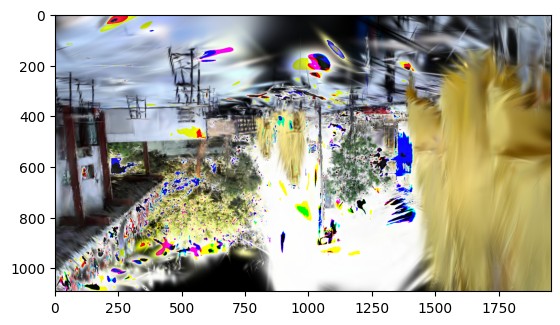

In [33]:
plt.imshow((render(test_camera, gaussians, pipeline, background)['render'].permute(1, 2, 0) * 255).to(torch.uint8).detach().cpu())

In [20]:
test_camera.image_name

'fake'

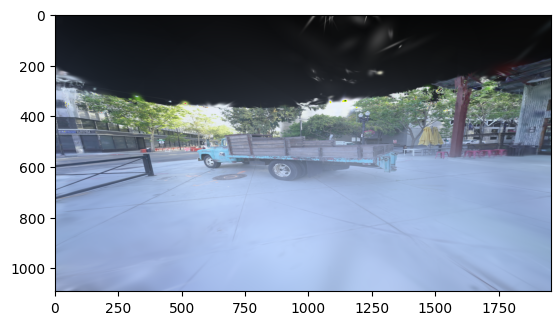

In [27]:
plt.imshow(render_kaolin(kal_cam))

In [16]:
copy.deepcopy(kal_cam).cam_pos()

tensor([[[ 3.3990],
         [ 0.6835],
         [-2.2992]]])

In [15]:
dir(kal_cam)

['__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__torch_function__',
 '__weakref__',
 '_extrinsics_constructors',
 '_intrinsics_constructors',
 'cat',
 'cpu',
 'cuda',
 'device',
 'double',
 'dtype',
 'extrinsics',
 'float',
 'from_args',
 'gradient_mask',
 'half',
 'height',
 'intrinsics',
 'lens_type',
 'named_params',
 'parameters',
 'requires_grad_',
 'to',
 'transform',
 'view_projection_matrix',
 'width']

In [10]:
focus_at

tensor([0.9279, 0.4308, 0.8361])

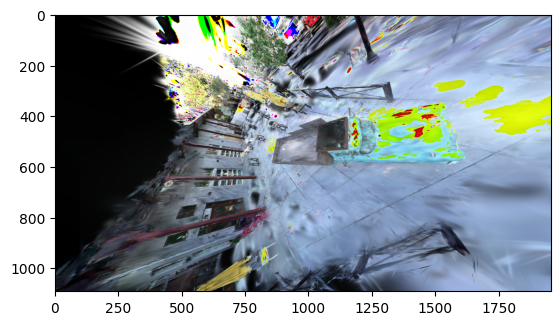

In [5]:
plt.imshow(visualizer.current_output['img'])

render: [3, 1091, 1957] (torch.float32)[cuda:0]  - [min 0.0082, max 1.8473, mean 0.4844] 
viewspace_points: [2597941, 3] (torch.float32)[cuda:0]  - [min 0.0000, max 0.0000, mean 0.0000] 
visibility_filter: [2597941] (torch.bool)[cuda:0]  - [min 0.0000, max 1.0000, mean 0.4351] 
radii: [2597941] (torch.int32)[cuda:0]  - [min 0.0000, max 7881.0000, mean 5.2377] 


Canvas(height=512, width=512)

Output()

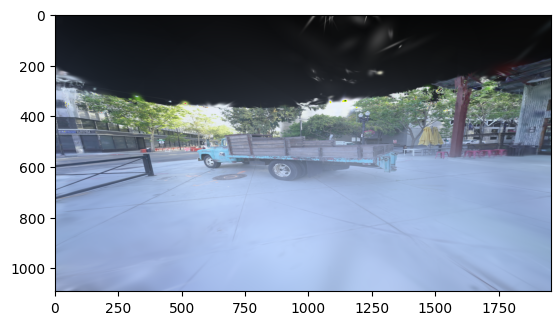

In [2]:
import copy
import ipywidgets
import json
import kaolin
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torchvision

# Gaussian splatting dependencies
from utils.graphics_utils import focal2fov
from utils.system_utils import searchForMaxIteration
from gaussian_renderer import render, GaussianModel
from scene.cameras import Camera as GSCamera

def log_tensor(t, name, **kwargs):
    print(kaolin.utils.testing.tensor_info(t, name=name, **kwargs))

%load_ext autoreload
%autoreload 2
%matplotlib inline
class PipelineParamsNoparse:
    """ Same as PipelineParams but without argument parser. """
    def __init__(self):
        self.convert_SHs_python = False
        self.compute_cov3D_python = False
        self.debug = False

        
def load_checkpoint(model_path, sh_degree=3, iteration=-1):
    # Find checkpoint
    checkpt_dir = os.path.join(model_path, "point_cloud")
    if iteration == -1:
        iteration = searchForMaxIteration(checkpt_dir)
    checkpt_path = os.path.join(checkpt_dir, f"iteration_{iteration}", "point_cloud.ply")
    # checkpt_path = "/app/output/09ac9260-2/point_cloud/iteration_7000/point_cloud.ply"
    
    # Load guassians
    gaussians = GaussianModel(sh_degree)
    gaussians.load_ply(checkpt_path)                                                 
    return gaussians


def try_load_camera(model_path):
    """ Load one of the default cameras for the scene. """
    cam_path = os.path.join(model_path, 'cameras.json')
    if not os.path.exists(cam_path):
        print(f'Could not find saved cameras for the scene at {camp_path}; using default for ficus.')
        return GSCamera(colmap_id=0,
                        R=np.array([[-9.9037e-01,  2.3305e-02, -1.3640e-01], [ 1.3838e-01,  1.6679e-01, -9.7623e-01], [-1.6444e-09, -9.8571e-01, -1.6841e-01]]), 
                        T=np.array([6.8159e-09, 2.0721e-10, 4.03112e+00]), 
                        FoVx=0.69111120, FoVy=0.69111120, 
                        image=torch.zeros((3, 800, 800)),  # fake 
                        gt_alpha_mask=None, image_name='fake', uid=0)
        
    with open(cam_path) as f:
        data = json.load(f)
        raw_camera = data[0]
        
    tmp = np.zeros((4, 4))
    tmp[:3, :3] = raw_camera['rotation']
    tmp[:3, 3] = raw_camera['position']
    tmp[3, 3] = 1
    C2W = np.linalg.inv(tmp)
    R = C2W[:3, :3].transpose()
    T = C2W[:3, 3]
    width = raw_camera['width']
    height = raw_camera['height']
    fovx = focal2fov(raw_camera['fx'], width)
    fovy = focal2fov(raw_camera['fy'], height)
    return GSCamera(colmap_id=0,
                    R=R, T=T, FoVx=fovx, FoVy=fovy, 
                    image=torch.zeros((3, height, width)),  # fake 
                    gt_alpha_mask=None, image_name='fake', uid=0)


# model_path = 'output/fa41de0a-3'
model_path = '/app/output/09ac9260-2/'
gaussians = load_checkpoint(model_path)
pipeline = PipelineParamsNoparse()
background = torch.tensor([0, 0, 0], dtype=torch.float32, device="cuda")
test_camera = try_load_camera(model_path)

render_res = render(test_camera, gaussians, pipeline, background)
rendering = render_res["render"]
for k in render_res.keys():
    log_tensor(render_res[k], k, print_stats=True)
plt.imshow((rendering.permute(1, 2, 0) * 255).to(torch.uint8).detach().cpu().numpy())

def compute_cam_fov(intrinsics, axis='x'):
    # compute FOV from focal
    aspectScale = intrinsics.width / 2.0
    tanHalfAngle = aspectScale / (intrinsics.focal_x if axis == 'x' else intrinsics.focal_y).item()
    fov = np.arctan(tanHalfAngle) * 2
    return fov

def convert_kaolin_camera(kal_camera):
    """ Convert kaolin camera to GS camera. """
    R = kal_camera.extrinsics.R[0]
    R[1:3] = -R[1:3]
    T = kal_camera.extrinsics.t.squeeze()
    T[1:3] = -T[1:3]
    return GSCamera(colmap_id=0,
                    R=R.transpose(1, 0).cpu().numpy(), 
                    T=T.cpu().numpy(), 
                    FoVx=compute_cam_fov(kal_camera.intrinsics, 'x'), 
                    FoVy=compute_cam_fov(kal_camera.intrinsics, 'y'), 
                    image=torch.zeros((3, kal_camera.height, kal_camera.width)),  # fake 
                    gt_alpha_mask=None,
                    image_name='fake',
                    uid=0)

def convert_gs_camera(gs_camera):
    """ Convert GS camera to Kaolin camera. """
    view_mat = gs_camera.world_view_transform.transpose(1, 0)
    view_mat[1:3] = -view_mat[1:3]
    res = kaolin.render.camera.Camera.from_args(
        view_matrix=view_mat,
        width=gs_camera.image_width, height=gs_camera.image_height,
        fov=gs_camera.FoVx, device='cpu')
    return res

# Test that we can render the same thing
kal_cam = convert_gs_camera(test_camera)
test_cam_back = convert_kaolin_camera(kal_cam)
rendering = render(test_cam_back, gaussians, pipeline, background)["render"]
plt.imshow((rendering.permute(1, 2, 0) * 255).to(torch.uint8).detach().cpu().numpy())

# DEBUG 
# print(f'orig view matrix: {test_camera.world_view_transform}')
# print(f'new view_matrix: {test_cam_back.world_view_transform}')
# print(f'orig camera center: {test_camera.camera_center}')
# print(f'new camera center: {test_cam_back.camera_center}')
def render_kaolin(kaolin_cam):
    cam = convert_kaolin_camera(kaolin_cam)
    render_res = render(cam, gaussians, pipeline, background)
    rendering = render_res["render"]
    return (rendering.permute(1, 2, 0) * 255).to(torch.uint8).detach().cpu()

focus_at = (kal_cam.cam_pos() - 4. * kal_cam.extrinsics.cam_forward()).squeeze()
visualizer = kaolin.visualize.IpyTurntableVisualizer(
    512, 512, copy.deepcopy(kal_cam), render_kaolin, 
    focus_at=focus_at, world_up_axis=2, max_fps=12)
visualizer.show()


## 测试ipycanvas

In [24]:
from math import pi

from ipycanvas import Canvas

canvas = Canvas(width=1600, height=1200, layout=dict(width="100%"))

canvas.fill_style = "#8ee05e"
canvas.fill_rect(0, 0, canvas.width, canvas.height)

canvas.fill_style = "#f5f533"
canvas.fill_circle(canvas.width / 2.0, canvas.height / 2.0, 500)

canvas.stroke_style = "black"
canvas.line_width = 30
canvas.stroke_circle(canvas.width / 2.0, canvas.height / 2.0, 500)

canvas.fill_style = "black"
canvas.fill_circle(canvas.width / 2.7, canvas.height / 3.0, 100)  # Right eye
canvas.stroke_arc(canvas.width / 2.0, canvas.height / 2.0, 400, 0, pi, False)  # Mouth
canvas.stroke_arc(
 canvas.width - canvas.width / 2.7, canvas.height / 2.7, 100, 0, pi, True
)  # Left eye

canvas

Canvas(height=1200, layout=Layout(width='100%'), width=1600)